In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../dataset_generator/")
import environments

import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import scipy.stats
import stats

from tqdm import tqdm
import analysis_tools

In [3]:
model_name = f"../models/al1_10_l2_0"
path = f"../models/{model_name}"
model, params = analysis_tools.load_model(path, device = "cpu", model_type = "RNN")

## Elongation experiment

In [4]:
timesteps = 500000
env = environments.Environments()

In [5]:
sequence = ["square"]

In [6]:
scales = [1, 2, 3, 3.5] # scaling relative to square
y_bins = np.linspace(-1, 1, 32) # no y stretch

p_maps = []
g_maps = []

for scale in scales:
    env = environments.Environments()
    env.envs["square"]= env.envs["square"]*np.array([scale, 1])[None,None] # stretch walls of environment!
    x, r, v, c = analysis_tools.test_dataset(sequence, timesteps = timesteps, context = params["context"], env = env) # create dataset
    dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(sequence))] # repackage
    gs, ps, centers, preds = model.inference(dataset)

    # extra bins for stretched environment, x-direction!
    x_bins = np.linspace(-scale, scale, int(scale*32))
    stretch_bins = [[x_bins, y_bins]] 
    
    p_maps.append(stats.ratemaps(ps, r, stretch_bins, smooth = True).squeeze())
    g_maps.append(stats.ratemaps(gs, r, stretch_bins, smooth = True).squeeze())

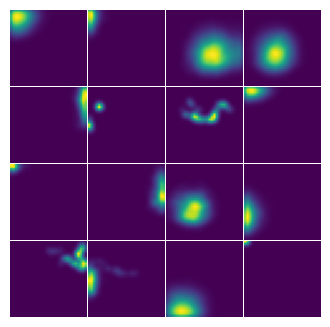

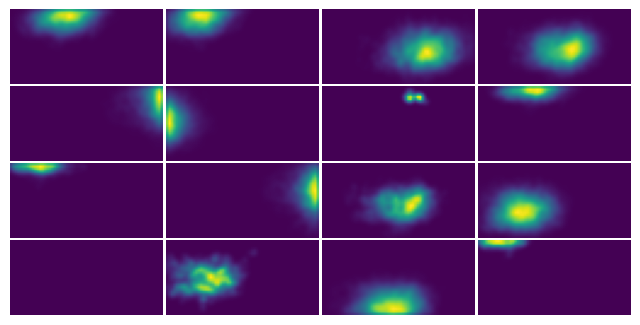

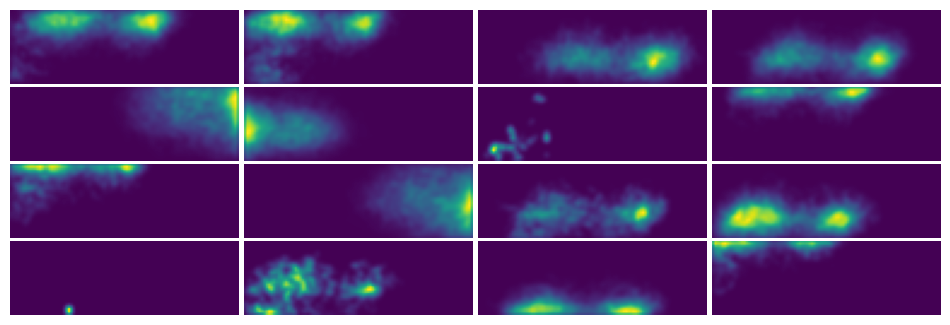

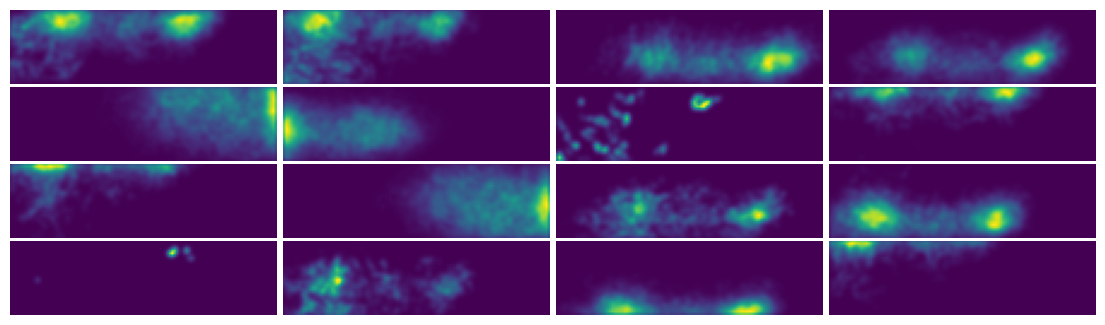

In [7]:
for i, p in enumerate(p_maps):
    analysis_tools.plot_ensemble(p, n = 4, pane_size=(scales[i], 1))
    plt.subplots_adjust(hspace = 0, wspace = 0.025)

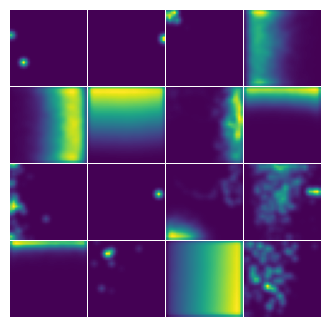

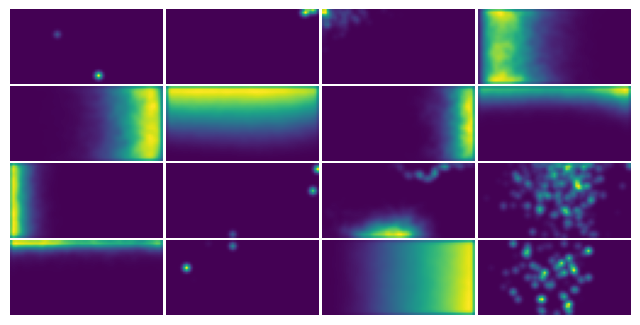

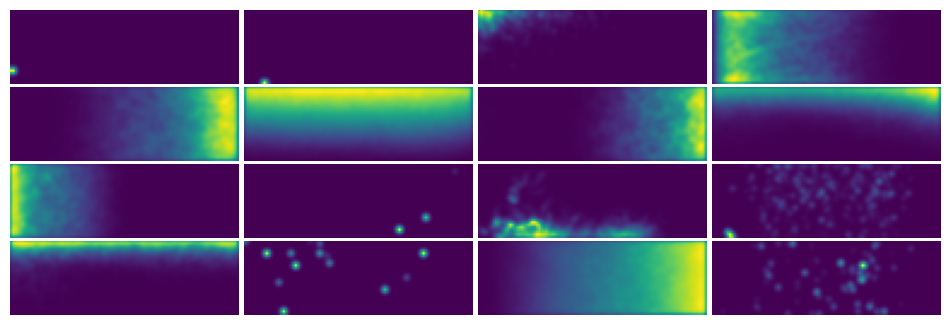

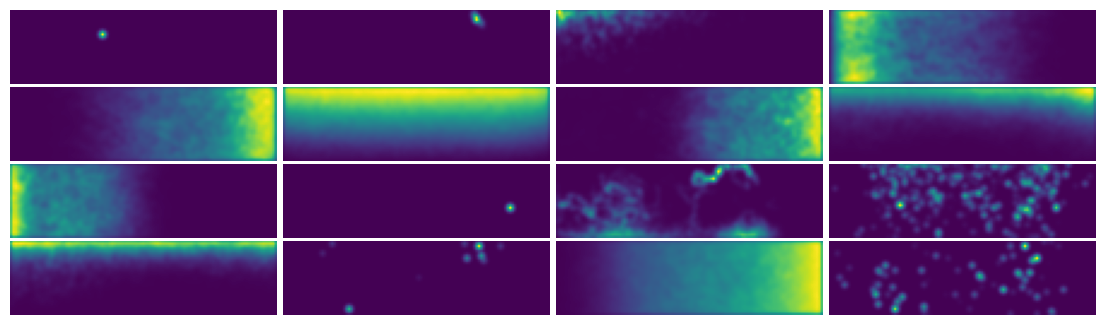

In [8]:
mask = np.sum(g_maps[0], axis = (-2, -1)) > 0 
for i, g in enumerate(g_maps):
    analysis_tools.plot_ensemble(g[mask], n = 4, pane_size=(scales[i], 1))
    plt.subplots_adjust(hspace = 0, wspace = 0.025)

In [12]:
# Elongate in both x and y directions

scales = [1, 2, 3, 4] # scaling relative to square

l_p_maps = []
l_g_maps = []

for scale in scales:
    env = environments.Environments()
    env.envs["square"]= env.envs["square"]*np.array([scale, scale])[None,None] # stretch walls of environment!
    x, r, v, c = analysis_tools.test_dataset(sequence, timesteps = timesteps, context = params["context"], env = env) # create dataset
    dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(sequence))] # repackage
    gs, ps, centers, preds = model.inference(dataset)

    # extra bins for stretched environment
    x_bins = np.linspace(-scale, scale, int(scale*32*0.5))
    y_bins = np.linspace(-scale, scale, int(scale*32*0.5))

    stretch_bins = [[x_bins, y_bins]] 
    
    l_p_maps.append(stats.ratemaps(ps, r, stretch_bins, smooth = True).squeeze())
    l_g_maps.append(stats.ratemaps(gs, r, stretch_bins, smooth = True).squeeze())

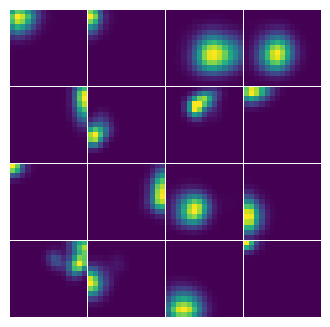

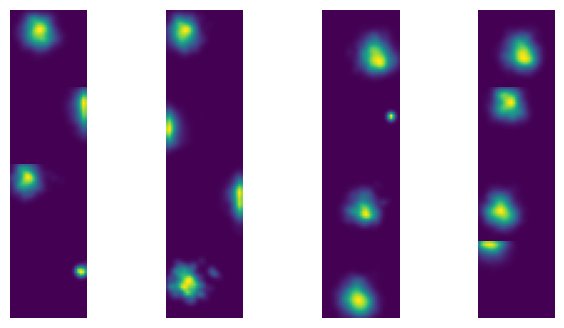

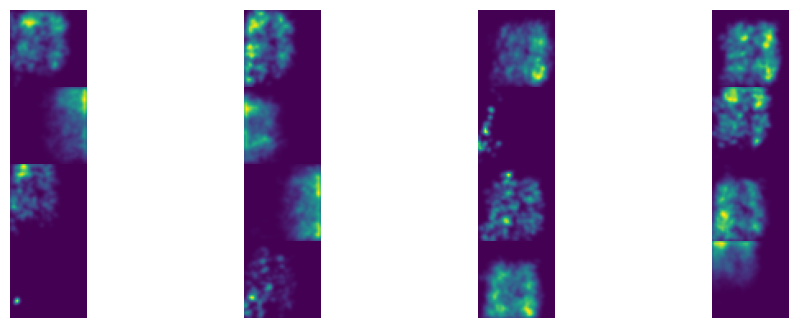

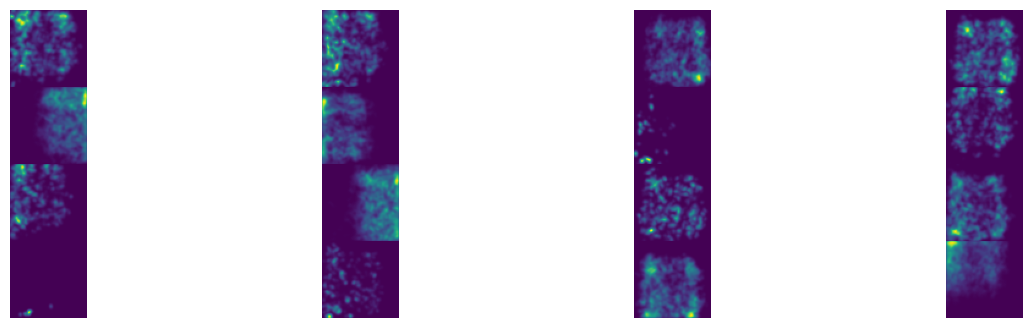

In [13]:
for i, p in enumerate(l_p_maps):
    analysis_tools.plot_ensemble(p, n = 4, pane_size=(scales[i], 1))
    plt.subplots_adjust(hspace = 0, wspace = 0.025)

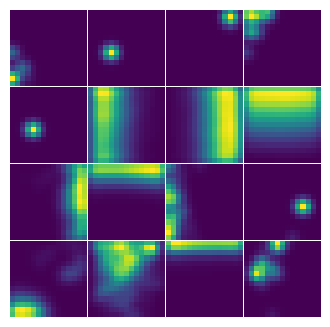

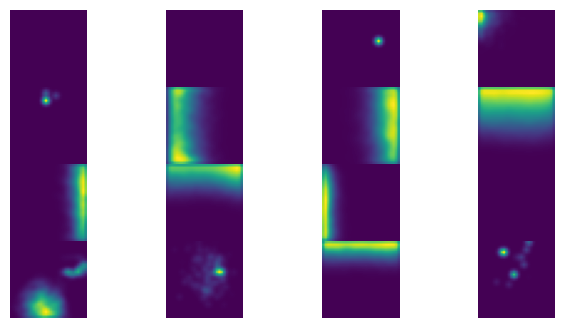

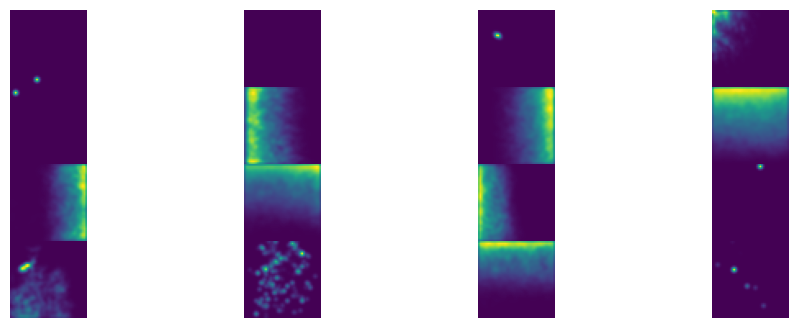

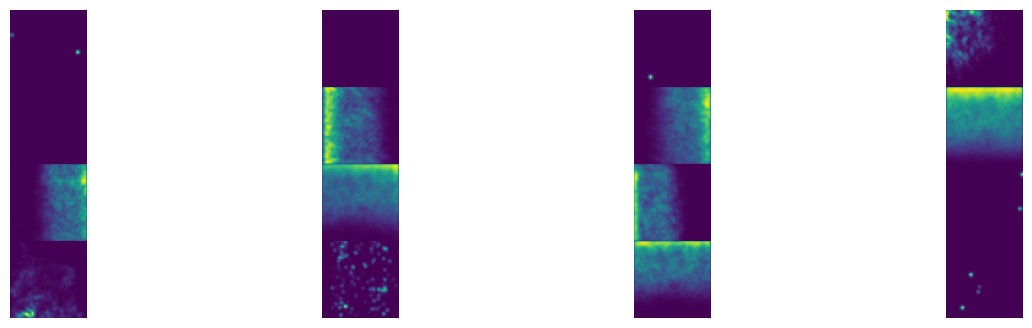

In [14]:
mask = np.sum(l_g_maps[0], axis = (-2, -1)) > 0 
for i, g in enumerate(l_g_maps):
    analysis_tools.plot_ensemble(g[mask], n = 4, pane_size=(scales[i], 1))
    plt.subplots_adjust(hspace = 0, wspace = 0.025)